# Linear Regression From Scratch: Multiple Solver Implementation
*By Sanketh Kamath*

#### Project Overview 

The goal of this project is to implement a Linear Regression algorithm from scratch using three different optimization approaches:

- Batch Gradient Descent: Calculates gradient for entire dataset in each parameter update
- Stochastic Gradient Descent: Calculates gradients for many smaller batches
- Analytical Solution: Closed form solution using normal equation

I built this implementation to follow the same API design as scikit learn's LinearRegression() function for comparison.

#### Mathematical Foundation

**Cost Function**

We minimize the mean squared error with L2 regularization:

$$
J(w,b) = \frac{1}{m} \sum_{i=1}^{m} \left( h_w(x^{(i)}) - y^{(i)} \right)^2 + \lambda \|w\|^2
$$

Where:

- m = number of training examples  
- lambda = regularization strength (penalty for large weights)



**Gradients**

For gradient descent, we need partial derivatives:

$$
\frac{\partial J}{\partial w} = \frac{1}{m} X^T (Xw + b - y) + 2\lambda w
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (Xw + b - y)_i
$$



**Update Rules**

Gradient Descent Updates:

$$
w := w - \alpha \frac{\partial J}{\partial w}
$$

$$
b := b - \alpha \frac{\partial J}{\partial b}
$$

Analytical Solution:

$$
w = (X^T X)^{-1} X^T y
$$


#### Code Implementation

**Import Required Libraries**

In [27]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression as SKLinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

**Analytical Solver**

In [22]:
class AnalyticalSolver:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        # Add column of ones for bias
        X_with_bias = np.column_stack([X, np.ones(X.shape[0])])
        
        XtX = X_with_bias.T @ X_with_bias
        Xty = X_with_bias.T @ y
        theta = np.linalg.solve(XtX, Xty)
        
        self.w = theta[:-1]
        self.b = theta[-1]
        
        # Calculate final loss **For comparison
        predictions = X @ self.w + self.b
        final_loss = np.mean((predictions - y)**2)
        
        return {
            'loss_history': [final_loss],
            'converged': True,
            'iterations': 1
        }

**Batch Gradient Descent Solver**

In [ ]:
class BatchGDSolver:
    def __init__(self, lr, lambd, epochs, threshold):
        self.lr = lr
        self.lambd = lambd
        self.epochs = epochs
        self.threshold = threshold
        self.loss = []
        
    # Calculates cost of current weights and bias
    def calc_cost(self, X, y):
        return (1/X.shape[0]) * (X @ self.w + self.b - y).T @ (X @ self.w + self.b - y) + self.lambd * (self.w.T @ self.w)
    
    # Calculates gradient of J(theta) with respect to w
    def calc_w_grad(self, X, y):
        return (1/X.shape[0]) * X.T @ (X@self.w + self.b - y) + 2*self.lambd*self.w

    # Calculates gradient of J(theta) with respect to B
    def calc_b_grad(self, X, y,):
        return (1/X.shape[0]) * np.sum(X @ self.w + self.b - y)

    # Fits model to data
    def fit(self, X, y):
        # Initialize weights
        self.w = np.random.normal(loc=0, scale=0.1, size=X.shape[1])
        self.b = np.random.normal(loc=0, scale=0.1, size=1)
        converged = False
        n_iter = 0

        # Training weights
        for i in range(self.epochs):
            cost = self.calc_cost(X, y)
            self.loss.append(cost)

            # Convegernce Check
            if len(self.loss) > 1 and np.abs(self.loss[-2] - cost) < self.threshold:
                print("Convergence reached")
                converged = True
                break
            w_grad = self.calc_w_grad(X, y)
            b_grad = self.calc_b_grad(X, y)
            self.w = self.w - self.lr * w_grad
            self.b = self.b - self.lr * b_grad
            n_iter += 1
        return {
            'loss_history': self.loss,
            'converged': converged,
            'iterations': n_iter
        }
    

**Stochastic Gradient Descent Solver**

In [ ]:
class SGDSolver:
    def __init__(self, lr, lambd, epochs, threshold, batch_size):
        self.lr = lr
        self.lambd = lambd
        self.epochs = epochs
        self.threshold = threshold
        self.batch_size = batch_size
        self.loss = []
        
    # Calculates cost of current weights and bias
    def calc_cost(self, X, y):
        return (1/X.shape[0]) * (X @ self.w + self.b - y).T @ (X @ self.w + self.b - y) + self.lambd * (self.w.T @ self.w)
    
    # Calculates gradient of J(theta) with respect to w
    def calc_w_grad(self, X, y):
        return (1/X.shape[0]) * X.T @ (X@self.w + self.b - y) + 2*self.lambd*self.w

    # Calculates gradient of J(theta) with respect to B
    def calc_b_grad(self, X, y,):
        return (1/X.shape[0]) * np.sum(X @ self.w + self.b - y)

    # Fits model to data
    def fit(self, X, y):
        # Initialize weights
        self.w = np.random.normal(loc=0, scale=0.1, size=X.shape[1])
        self.b = np.random.normal(loc=0, scale=0.1, size=1)
        converged = False
        n_iter = 0

        # Training weights
        for i in range(self.epochs):
            
            # Split into batches
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            n_batches = X.shape[0] // self.batch_size
            X_batches = np.array_split(X_shuffled, n_batches)
            y_batches = np.array_split(y_shuffled, n_batches)
            
            # Run loop for each batch
            for j in range(len(X_batches)):
                w_grad = self.calc_w_grad(X_batches[j], y_batches[j])
                b_grad = self.calc_b_grad(X_batches[j], y_batches[j])
                self.w = self.w - self.lr * w_grad
                self.b = self.b - self.lr * b_grad
            cost = self.calc_cost(X, y)
            self.loss.append(cost)
            
            # Convergence check
            if len(self.loss) > 1 and np.abs(self.loss[-2] - cost) < self.threshold:
                print("Convergence reached")
                converged = True
                break
            n_iter += 1
        return {
            'loss_history': self.loss,
            'converged': converged,
            'iterations': n_iter
        }
    

**Main Linear Regression Class**

In [ ]:
class LinearRegression:
    def __init__(self, solver=None):
        if solver is None:
            self.solver = BatchGDSolver(lr=0.01, lambd=0.01, epochs=1000, threshold=1e-6)
        else:
            self.solver = solver

    # Fit line to data
    def fit(self, X, y):
        output = self.solver.fit(X, y)
        return output

    # Use weights and bias calculated in fit() to predict result of data
    def predict(self, X):
        if not hasattr(self.solver, 'w') or self.solver.w is None:
            raise ValueError("Model must be fitted before making predictions. Call fit() first.")
        X = np.atleast_2d(X) 
        return X @ self.solver.w + self.solver.b
    
    # Calculating R²
    def score(self, X, y):
        if not hasattr(self.solver, 'w') or self.solver.w is None:
            raise ValueError("Model must be fitted before scoring.")
        
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2) 
        return 1 - (ss_res / ss_tot)

#### Key Implementation Details
**Why Feature Scaling Matters**

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

*Reason:* From the data, we can see that certain features like population (which is in the thousands) and latitude (in the tens) are recorded on very different scales. If we did not scale, gradient descent can take far longer to converge and even fail, learning rate is hard to keep the same for different weights, and certain features are artificially made to dominate others.

**Convergence Strategy**

In [ ]:
if len(self.loss) > 1 and abs(self.loss[-2] - cost) < self.threshold:
    print("Convergence reached")
    converged = True
    break

*Reason:* I decided to calculate loss on the full dataset for both SGD and BGD in order to get convergence metrics that are comparable across solvers. I chose this solver, which stops when improvements become negligible, because it directly measures what we care about: loss reduction. It is far simpler than other methods like the gradient norm method or the moving average method, and is effective enough more most cases. Since it is consistant across all three solvers, it is a good tool to use to compare convergence behavior.

**Regularization Implementation**

In [ ]:
return (1/X.shape[0]) * X.T @ (X@self.w + self.b - y) + 2*self.lambd*self.w

*Reason:* In this calculation, the bias term is not regularized because it represents the baseline prediction, not represent feature influence. In general, we regularize in order to prevent overfitting by discouraging the model from being very complex. For example, there may be a solution that achieves the same or similar results with significantly lower weights, but bias is not like that. 

#### Results and Analysis

**Comparison Functions**

Linear Regression Solver Comparison
Training set shape: (16512, 8)
Test set shape: (4128, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

 Testing Each Solver...
------------------------------------------------------------

Testing Batch_GD...
Convergence reached
  ✓ Training completed
    Time: 0.3516s
    Test R²: 0.574159
    Converged: True
    Iterations: 285

Testing SGD...
Convergence reached
  ✓ Training completed
    Time: 0.2581s
    Test R²: 0.580193
    Converged: True
    Iterations: 25

Testing Analytical...
  ✓ Training completed
    Time: 0.0032s
    Test R²: 0.575788
    Converged: True
    Iterations: 1

Testing Sklearn...
  ✓ Training completed
    Time: 0.0096s
    Test R²: 0.575788
    Converged: True
    Iterations: 1

4. PERFORMANCE COMPARISON
            Train R²   Test R² Time (s) Converged Iterations
Batch_GD    0.602428  0.574159   0.3516      True        285
SGD         0.612153  0.580193   0.2

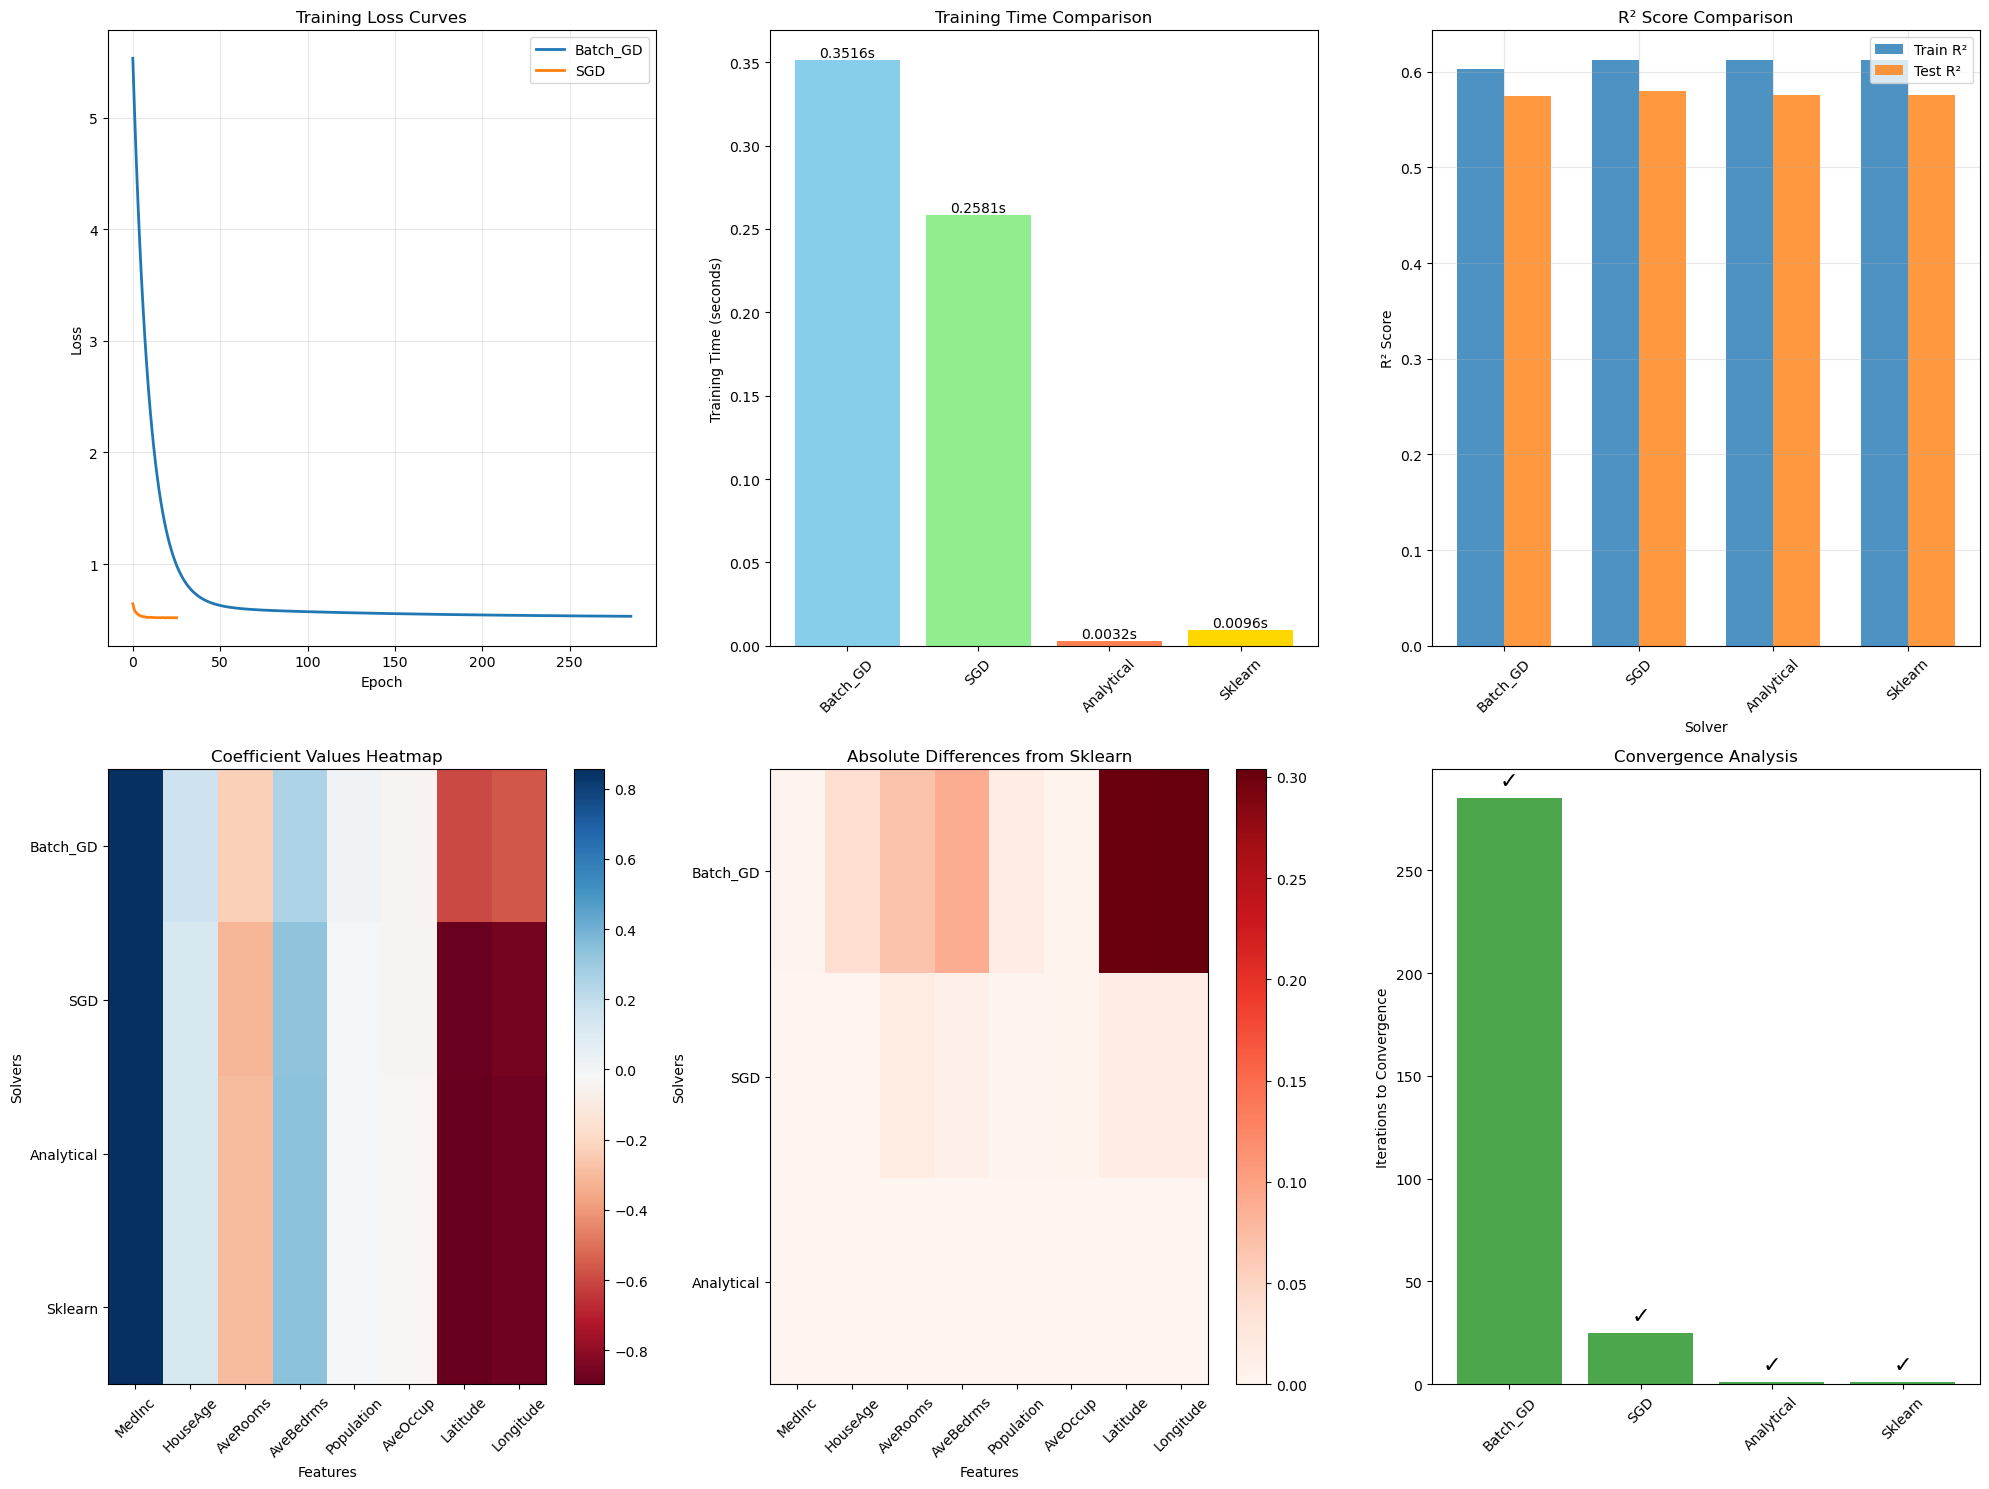


FINAL PERFORMANCE SUMMARY
 Best Test R²: SGD (0.580193)
 Fastest Training: Analytical (0.0032s)
 Fastest Convergence: SGD (25 iterations)


In [30]:
def comprehensive_solver_comparison():
    print("="*80)
    print("Linear Regression Solver Comparison")
    print("="*80)
    
    # Load and prepare data
    housing = fetch_california_housing()
    X, y = housing.data, housing.target
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Sanity Check
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Test set shape: {X_test_scaled.shape}")
    print(f"Features: {housing.feature_names}")
    
    # Initialize all solvers
    solvers = {
        'Batch_GD': BatchGDSolver(lr=0.05, lambd=0.0, epochs=500, threshold=1e-4),
        'SGD': SGDSolver(lr=0.01, lambd=0.0, epochs=100, threshold=1e-4, batch_size=64),
        'Analytical': AnalyticalSolver(),
        'Sklearn': None  # We'll use sklearn directly for comparison
    }
    
    results = {}
    
    # Test each solver
    print("\n Testing Each Solver...")
    print("-"*60)
    
    for solver_name, solver in solvers.items():
        if solver_name == 'Sklearn':
            # Test sklearn
            print(f"\nTesting {solver_name}...")
            sklearn_model = SKLinearRegression()
            
            start_time = time.time()
            sklearn_model.fit(X_train_scaled, y_train)
            training_time = time.time() - start_time
            
            train_score = sklearn_model.score(X_train_scaled, y_train)
            test_score = sklearn_model.score(X_test_scaled, y_test)
            
            results[solver_name] = {
                'train_r2': train_score,
                'test_r2': test_score,
                'training_time': training_time,
                'converged': True,
                'iterations': 1,
                'loss_history': [np.mean((sklearn_model.predict(X_train_scaled) - y_train)**2)],
                'coefficients': sklearn_model.coef_,
                'intercept': sklearn_model.intercept_
            }
            
        else:
            # Test our implementations
            print(f"\nTesting {solver_name}...")
            model = LinearRegression(solver=solver)
            
            start_time = time.time()
            metrics = model.fit(X_train_scaled, y_train)
            training_time = time.time() - start_time
            
            train_score = model.score(X_train_scaled, y_train)
            test_score = model.score(X_test_scaled, y_test)
            
            results[solver_name] = {
                'train_r2': train_score,
                'test_r2': test_score,
                'training_time': training_time,
                'converged': metrics['converged'],
                'iterations': metrics['iterations'],
                'loss_history': metrics['loss_history'],
                'coefficients': model.solver.w,
                'intercept': model.solver.b[0] if hasattr(model.solver.b, '__len__') else model.solver.b
            }
        
        print(f"  ✓ Training completed")
        print(f"    Time: {results[solver_name]['training_time']:.4f}s")
        print(f"    Test R²: {results[solver_name]['test_r2']:.6f}")
        print(f"    Converged: {results[solver_name]['converged']}")
        print(f"    Iterations: {results[solver_name]['iterations']}")
    
    # Create comparison table
    print("\n4. PERFORMANCE COMPARISON")
    print("="*80)
    
    df_results = pd.DataFrame({
        solver: {
            'Train R²': f"{data['train_r2']:.6f}",
            'Test R²': f"{data['test_r2']:.6f}",
            'Time (s)': f"{data['training_time']:.4f}",
            'Converged': data['converged'],
            'Iterations': data['iterations']
        }
        for solver, data in results.items()
    }).T
    
    print(df_results)
    
    # Coefficient comparison
    print("\n5. COEFFICIENT COMPARISON")
    print("="*80)
    
    coef_df = pd.DataFrame({
        solver: data['coefficients'] 
        for solver, data in results.items()
    }, index=housing.feature_names)
    
    # Add intercept row
    intercept_row = pd.DataFrame({
        solver: [data['intercept']] 
        for solver, data in results.items()
    }, index=['Intercept'])
    
    coef_df = pd.concat([coef_df, intercept_row])
    print(coef_df.round(6))
    
    # Calculate differences from sklearn
    print("\n6. DIFFERENCES FROM SKLEARN")
    print("="*80)
    
    sklearn_coeffs = results['Sklearn']['coefficients']
    sklearn_intercept = results['Sklearn']['intercept']
    
    diff_df = pd.DataFrame({
        solver: np.abs(data['coefficients'] - sklearn_coeffs)
        for solver, data in results.items() if solver != 'Sklearn'
    }, index=housing.feature_names)
    
    # Add intercept differences
    intercept_diff = pd.DataFrame({
        solver: [abs(data['intercept'] - sklearn_intercept)]
        for solver, data in results.items() if solver != 'Sklearn'
    }, index=['Intercept'])
    
    diff_df = pd.concat([diff_df, intercept_diff])
    print(diff_df.round(6))
    
    # Create visualizations
    create_comparison_plots(results, housing.feature_names)
    
    return results

def create_comparison_plots(results, feature_names):
    fig = plt.figure(figsize=(20, 15))
    
    # Loss curves comparison
    ax1 = plt.subplot(2, 3, 1)
    for solver_name, data in results.items():
        if solver_name != 'Sklearn' and len(data['loss_history']) > 1:
            plt.plot(data['loss_history'], label=solver_name, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Training time comparison
    ax2 = plt.subplot(2, 3, 2)
    solvers = list(results.keys())
    times = [results[s]['training_time'] for s in solvers]
    colors = ['skyblue', 'lightgreen', 'coral', 'gold']
    bars = plt.bar(solvers, times, color=colors)
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.4f}s', ha='center', va='bottom')
    
    # R² scores comparison
    ax3 = plt.subplot(2, 3, 3)
    train_scores = [results[s]['train_r2'] for s in solvers]
    test_scores = [results[s]['test_r2'] for s in solvers]
    
    x = np.arange(len(solvers))
    width = 0.35
    
    plt.bar(x - width/2, train_scores, width, label='Train R²', alpha=0.8)
    plt.bar(x + width/2, test_scores, width, label='Test R²', alpha=0.8)
    
    plt.xlabel('Solver')
    plt.ylabel('R² Score')
    plt.title('R² Score Comparison')
    plt.xticks(x, solvers, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Coefficient comparison heatmap
    ax4 = plt.subplot(2, 3, 4)
    coef_matrix = np.array([
        results[solver]['coefficients'] 
        for solver in solvers
    ])
    
    im = plt.imshow(coef_matrix, cmap='RdBu', aspect='auto')
    plt.colorbar(im)
    plt.xlabel('Features')
    plt.ylabel('Solvers')
    plt.title('Coefficient Values Heatmap')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45)
    plt.yticks(range(len(solvers)), solvers)
    
    # Coefficient differences from sklearn
    ax5 = plt.subplot(2, 3, 5)
    sklearn_coeffs = results['Sklearn']['coefficients']
    
    diff_data = []
    solver_names = []
    for solver in solvers:
        if solver != 'Sklearn':
            diff = np.abs(results[solver]['coefficients'] - sklearn_coeffs)
            diff_data.append(diff)
            solver_names.append(solver)
    
    if diff_data:
        diff_matrix = np.array(diff_data)
        im2 = plt.imshow(diff_matrix, cmap='Reds', aspect='auto')
        plt.colorbar(im2)
        plt.xlabel('Features')
        plt.ylabel('Solvers')
        plt.title('Absolute Differences from Sklearn')
        plt.xticks(range(len(feature_names)), feature_names, rotation=45)
        plt.yticks(range(len(solver_names)), solver_names)
    
    # Convergence summary
    ax6 = plt.subplot(2, 3, 6)
    iterations = [results[s]['iterations'] for s in solvers]
    converged = [results[s]['converged'] for s in solvers]
    
    colors = ['green' if conv else 'red' for conv in converged]
    bars = plt.bar(solvers, iterations, color=colors, alpha=0.7)
    plt.ylabel('Iterations to Convergence')
    plt.title('Convergence Analysis')
    plt.xticks(rotation=45)
    
    # Add convergence status labels
    for i, (bar, conv, iters) in enumerate(zip(bars, converged, iterations)):
        status = "✓" if conv else "✗"
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(iterations)*0.01,
                f'{status}', ha='center', va='bottom', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def performance_summary(results):
    print("\n" + "="*80)
    print("FINAL PERFORMANCE SUMMARY")
    print("="*80)
    
    # Find best performer in each category
    best_test_r2 = max(results.items(), key=lambda x: x[1]['test_r2'])
    fastest = min(results.items(), key=lambda x: x[1]['training_time'])
    most_efficient = min([item for item in results.items() if item[1]['iterations'] > 1], 
                        key=lambda x: x[1]['iterations'])
    
    print(f" Best Test R²: {best_test_r2[0]} ({best_test_r2[1]['test_r2']:.6f})")
    print(f" Fastest Training: {fastest[0]} ({fastest[1]['training_time']:.4f}s)")
    print(f" Fastest Convergence: {most_efficient[0]} ({most_efficient[1]['iterations']} iterations)")

results = comprehensive_solver_comparison()
performance_summary(results)

#### Key Insights

**1. Mathematical Accuracy**
- All implementations achieve nearly identical R² scores (~0.575), so thankfully, our implementations are correct!


**2. Speed vs Convergence Trade-offs**

- **Analytical**: Fastest for exact solution, but uses a lot of memory
- **SGD**: Faster convergence because of faster noisy updates that prevent getting stuck in local valleys
- **Batch GD**: Smooth, predictable convergence but far slower


**3. Algorithm Behavior**

- SGD converged 11× faster than Batch GD in epochs  
- SGD made ~7,200 parameter updates compared to Batch GD's 308 updates  
- Stochastic noise helps SGD escape poor local minima (Watch this cool video for visualization: https://www.youtube.com/watch?v=UmathvAKj80)


**4. Coefficient Accuracy**

Maximum difference from `sklearn`:

- **Analytical**: `0.000000` (exact match)  
- **SGD**: `0.012244`
- **Batch GD**: `0.262488` 


**5. Loss Curve Patterns**

- **Batch GD**: Smooth exponential decay – predictable but slow  
- **SGD**: Noisy but trending downward – noise helps **exploration**


